This script goes through the epochs and classes over 1000 epochs for Cifar-finer-3

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from util import stopwatch, get_stopwatch
import numpy as np
device = torch.device('cpu')# if torch.cuda.is_available() else 'cpu')

save_img_row_size = 8
label_list = "plane autos birds cats_ deer_ dogs_ frogs horse ships truck".split(" ")
def save_labels(labels, path):
    with open(path, 'w') as f:
        for i, label in enumerate(labels.detach().numpy()):
            l = np.where(label==1)[0][0]
            print(label_list[l], file=f, end=('\n' if (i+1) % save_img_row_size == 0 else ' '))
torch.manual_seed(7)

## TODO Try auxiliary task of determining class as way of improving generation
Also try CIFAR100 with word embeddings

In [2]:
num_epochs = 1000
batch_size = 100
sample_dir = 'samples_dc_cond_cifar_finer3'
num_labels = 10

if not os.path.exists(sample_dir): os.makedirs(sample_dir)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
def denorm(x): return ((x+1)/2).clamp(0,1)

def one_hot(x):
    r = torch.zeros(num_labels)
    try: r[x] = 1
    except: r[x.item()] = 1
    return r
dataset = torchvision.datasets.CIFAR10(root='~/cifar10-data/', train=True, download=True,
                                   transform=transform, target_transform=one_hot)

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
show_i = 4
print("{} images of {}".format(len(dataset), dataset[1][0].shape))
print(dataset[show_i][1])
print(dataset[show_i][0].shape)
plt.imshow(denorm(dataset[show_i][0].permute(1,2,0)))

50000 images of torch.Size([3, 32, 32])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([3, 32, 32])


In [4]:
latent_size = 64
image_size = 32 * 32
num_colors = 3
num_kernels = 32

D = nn.Sequential(
    # add label to each pixel in input. (10+3) * 32 * 32
    nn.Conv2d(num_labels+num_colors, num_kernels, 2, 2, 0),
    # 32x16x16
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels, num_kernels*2, 3, 2, 1),
    # 64x8x8
    nn.BatchNorm2d(num_kernels * 2),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*2, num_kernels*4, 2, 1),
    # 128x7x7
    nn.BatchNorm2d(num_kernels * 4),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*4, num_kernels*8, 2, 2),
    # 256x3x3
    nn.BatchNorm2d(num_kernels * 8),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*8, 1, 3),
    nn.Sigmoid())
D = D.to(device)
D_losses = []

G = nn.Sequential(
    nn.ConvTranspose2d(latent_size+num_labels, num_kernels*8, 3, 1, 0),
    # 256x3x3
    nn.BatchNorm2d(num_kernels*8),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*8, num_kernels*4, 2, 2, 1),
    # 128x5x5
    nn.BatchNorm2d(num_kernels*4),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 2, 2, 0, 1),
    # 64x9x9
    nn.BatchNorm2d(num_kernels*2),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*2, num_kernels*3//2, 3, 2, 1),
    nn.BatchNorm2d(num_kernels*3//2),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*3//2, num_kernels, 2, 1, 1),
    # 32x16x16
    nn.BatchNorm2d(num_kernels),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels, num_colors, 2, 2, 0),
    nn.Tanh())
#print(G(torch.zeros(1,74,1,1)).shape)
G = G.to(device)
G_losses = []

In [6]:
import pickle as pkl
#G.load_state_dict(torch.load(os.path.join(sample_dir, 'G_cond_339.ckpt')))
#D.load_state_dict(torch.load(os.path.join(sample_dir, 'D_cond_339.ckpt')))
losses = pkl.load(open(os.path.join(sample_dir, 'losses.pkl'), 'rb'))
#G_losses = losses['G_losses']; D_losses = losses['D_losses']

In [20]:
# [(image, [nearest_neighbours]), ...]
def generate_images(G, category, num, z=None):
    G.eval()
    if z is None: z = torch.randn(num, latent_size)
    z = z.to(device)
    # get num x num_labels matrix of one-hot vectors indicating the category
    labels = torch.zeros(num_labels)
    labels[category] = 1
    labels = labels.unsqueeze(0).expand(num, num_labels).to(device)
    g_inputs = torch.cat((z, labels), 1) # num * latent_dim
    g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> num * latent_dim * 1 * 1 for DC generator
    fake_images = G(g_inputs)
    return denorm(fake_images).detach()

ships
[5/5] (18.1s)


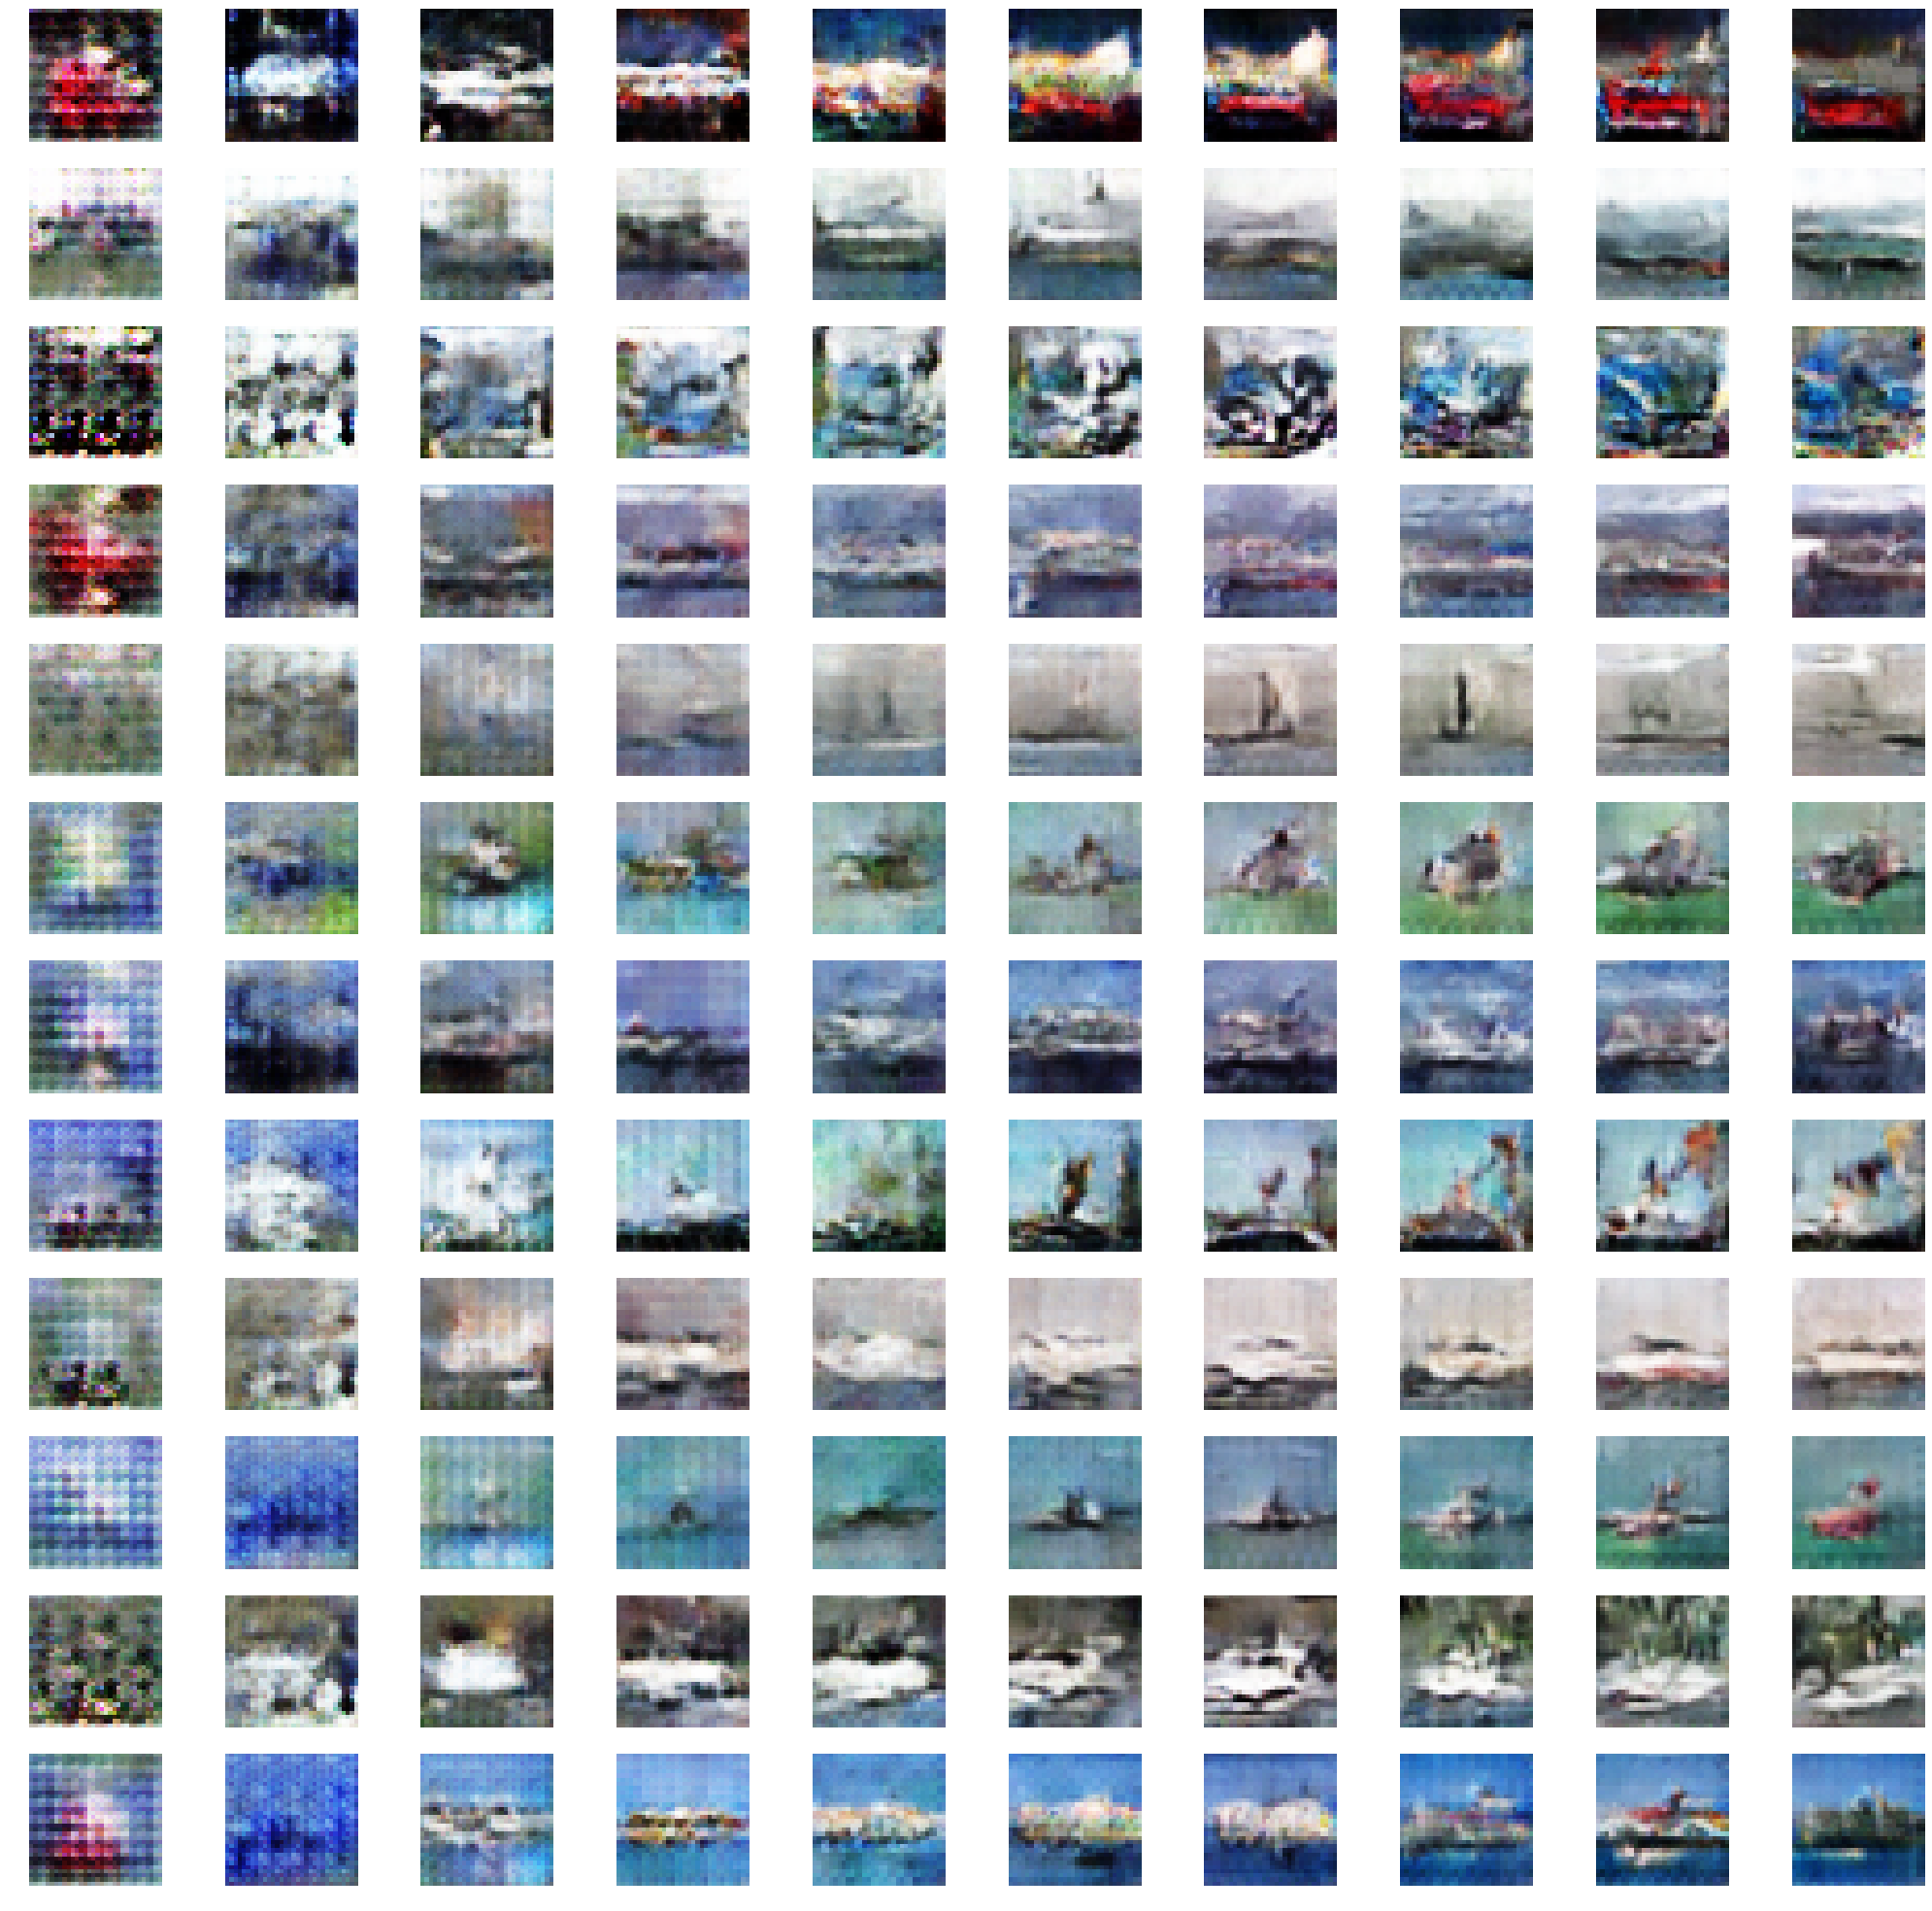

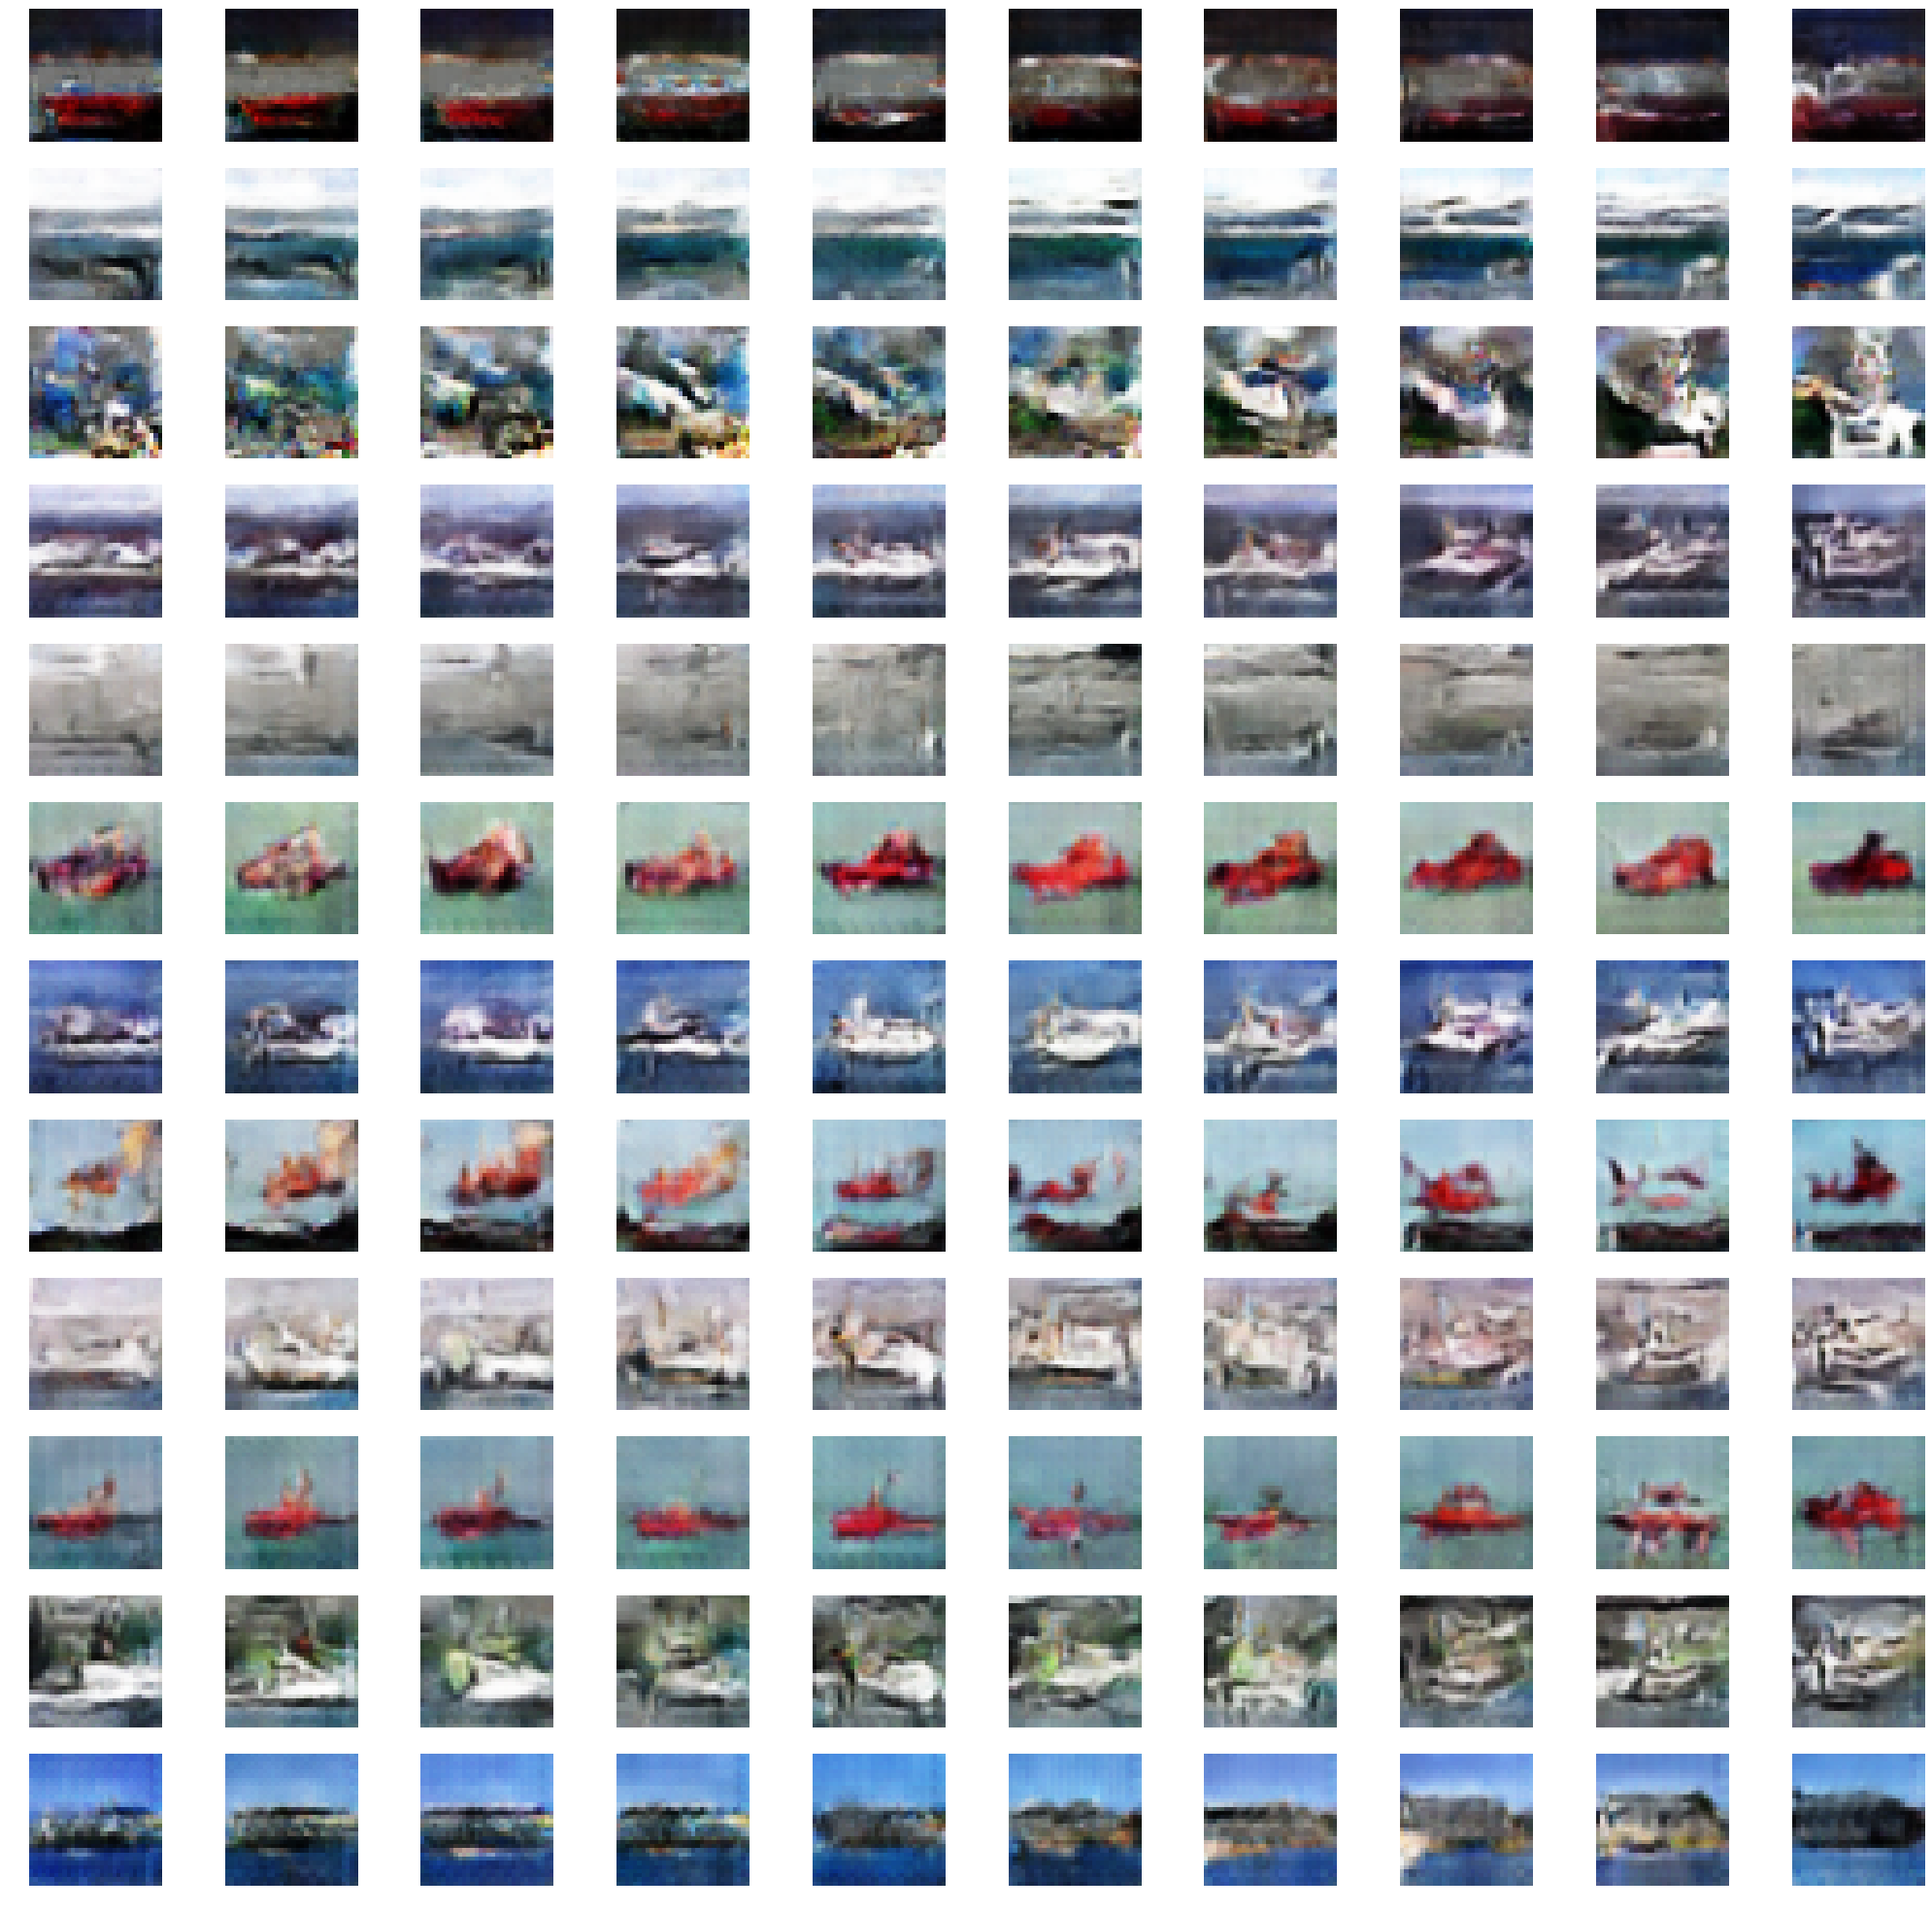

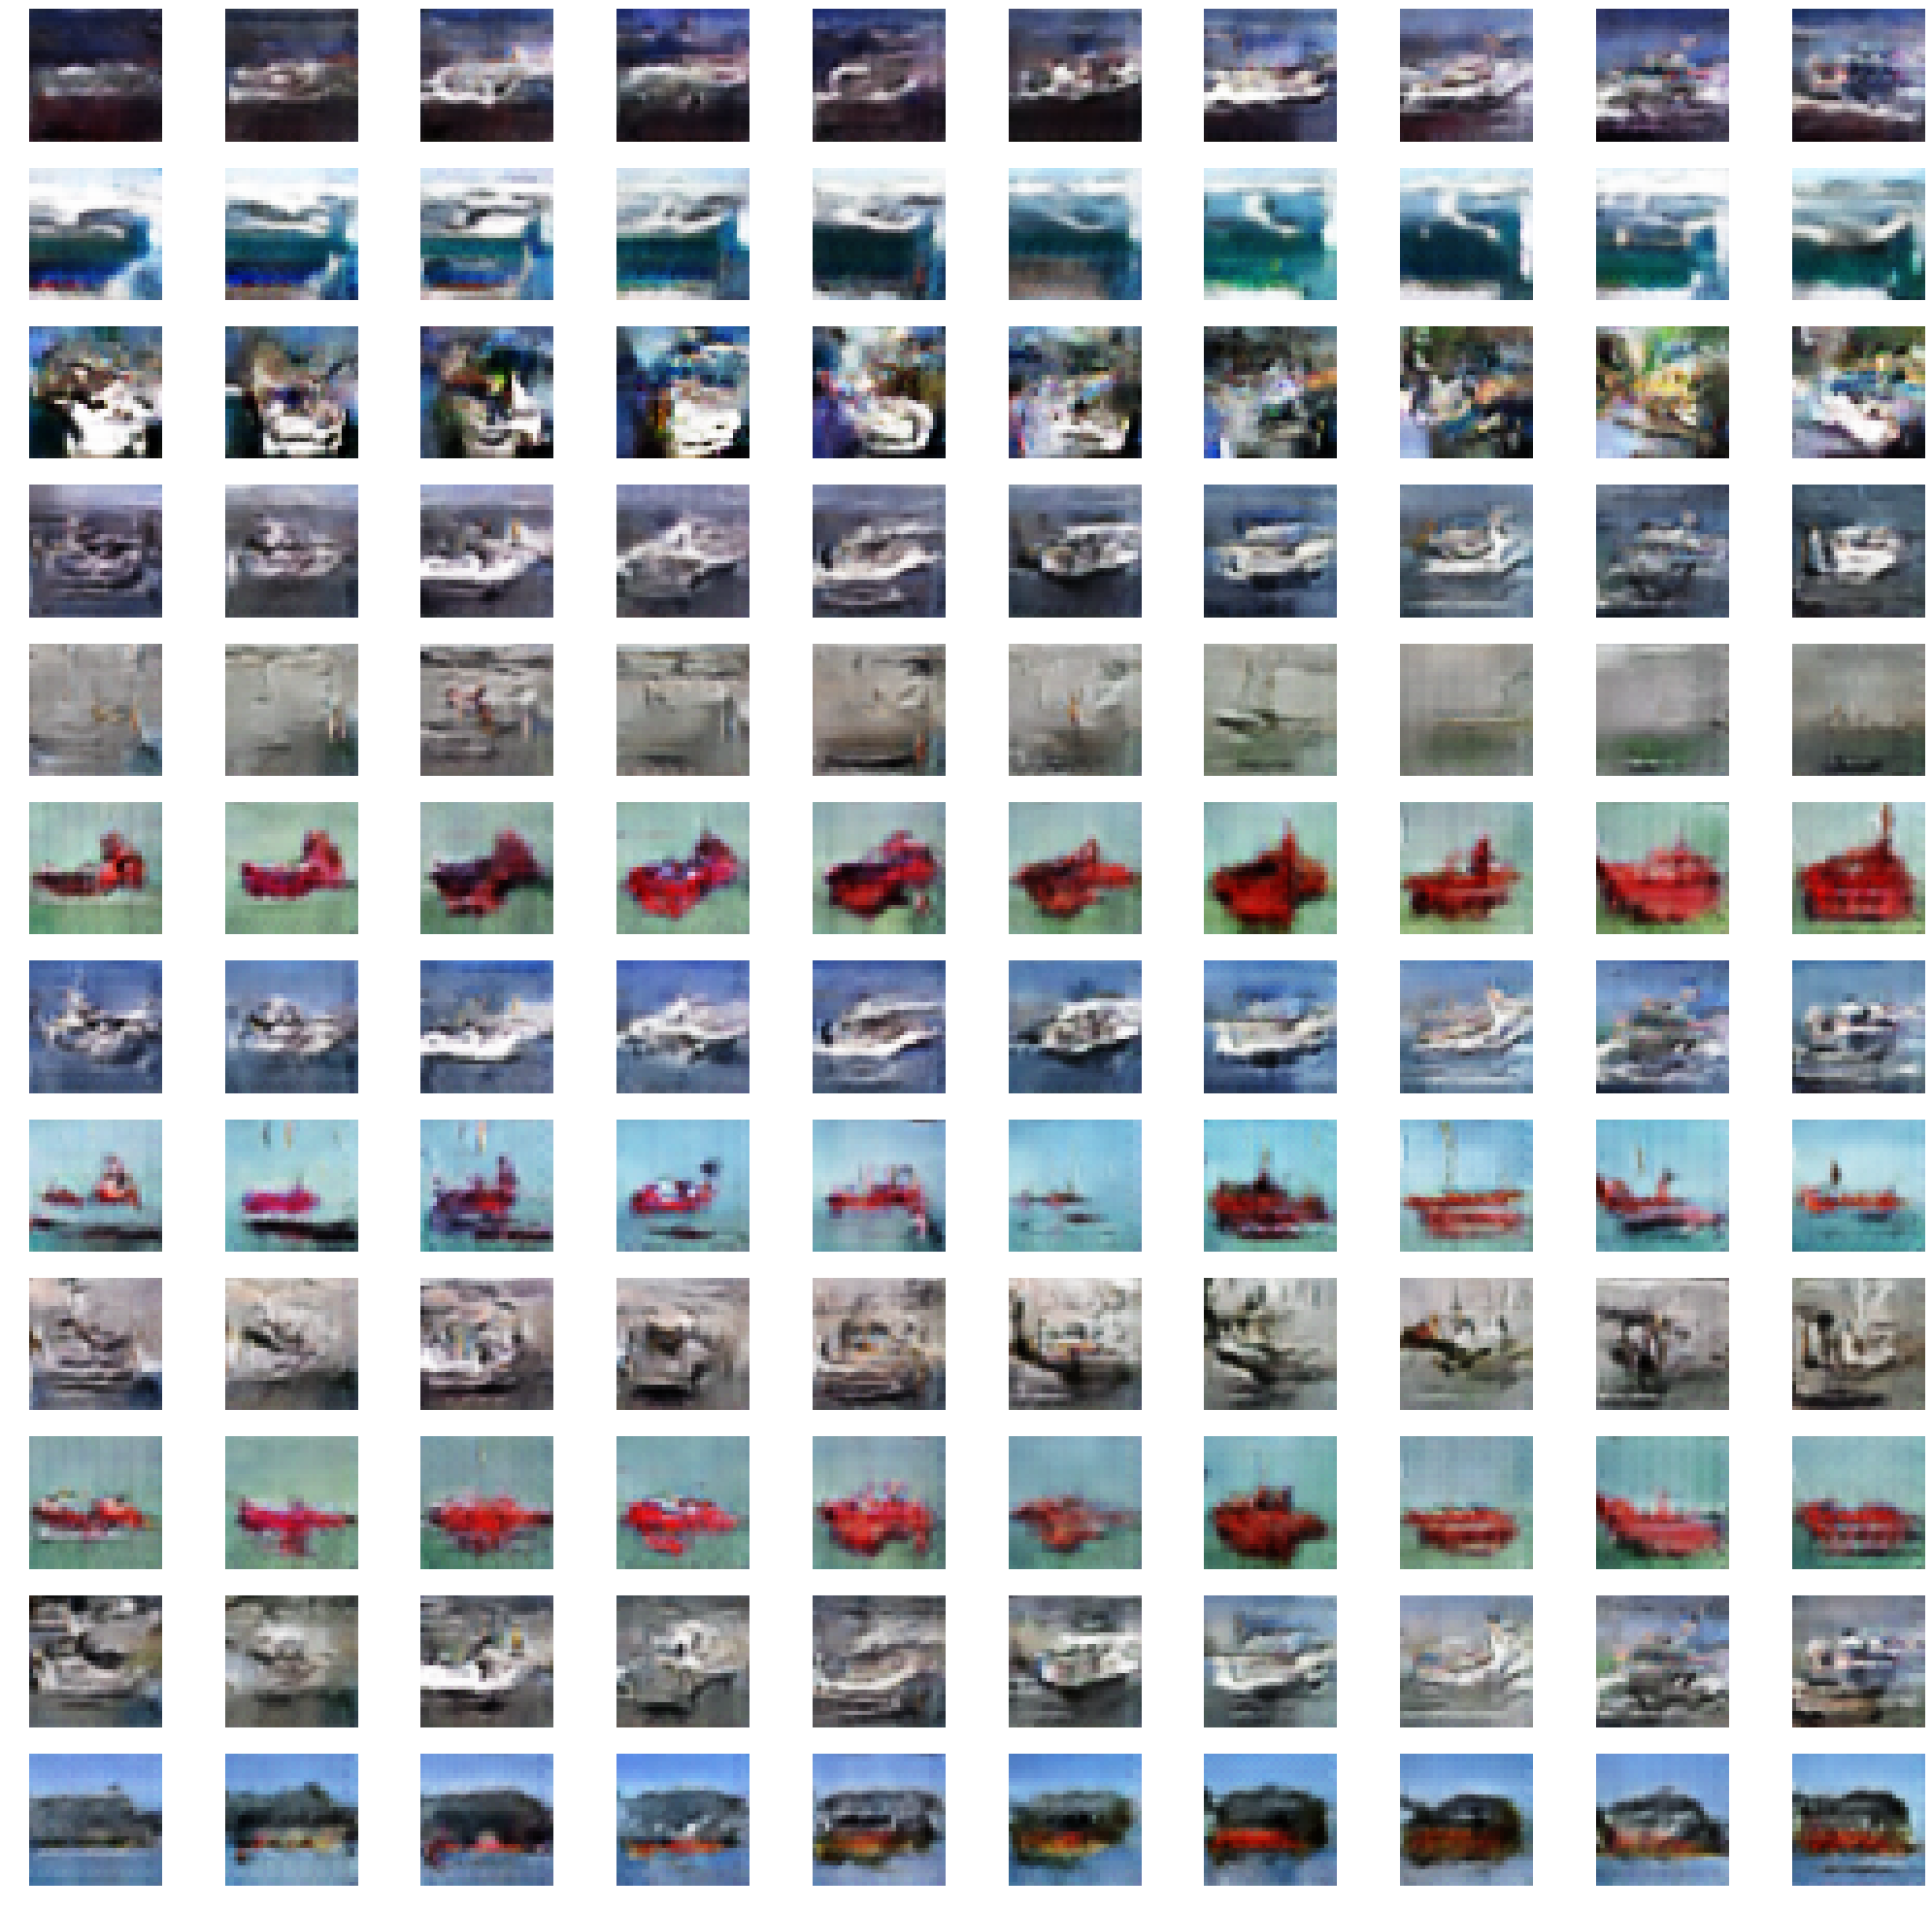

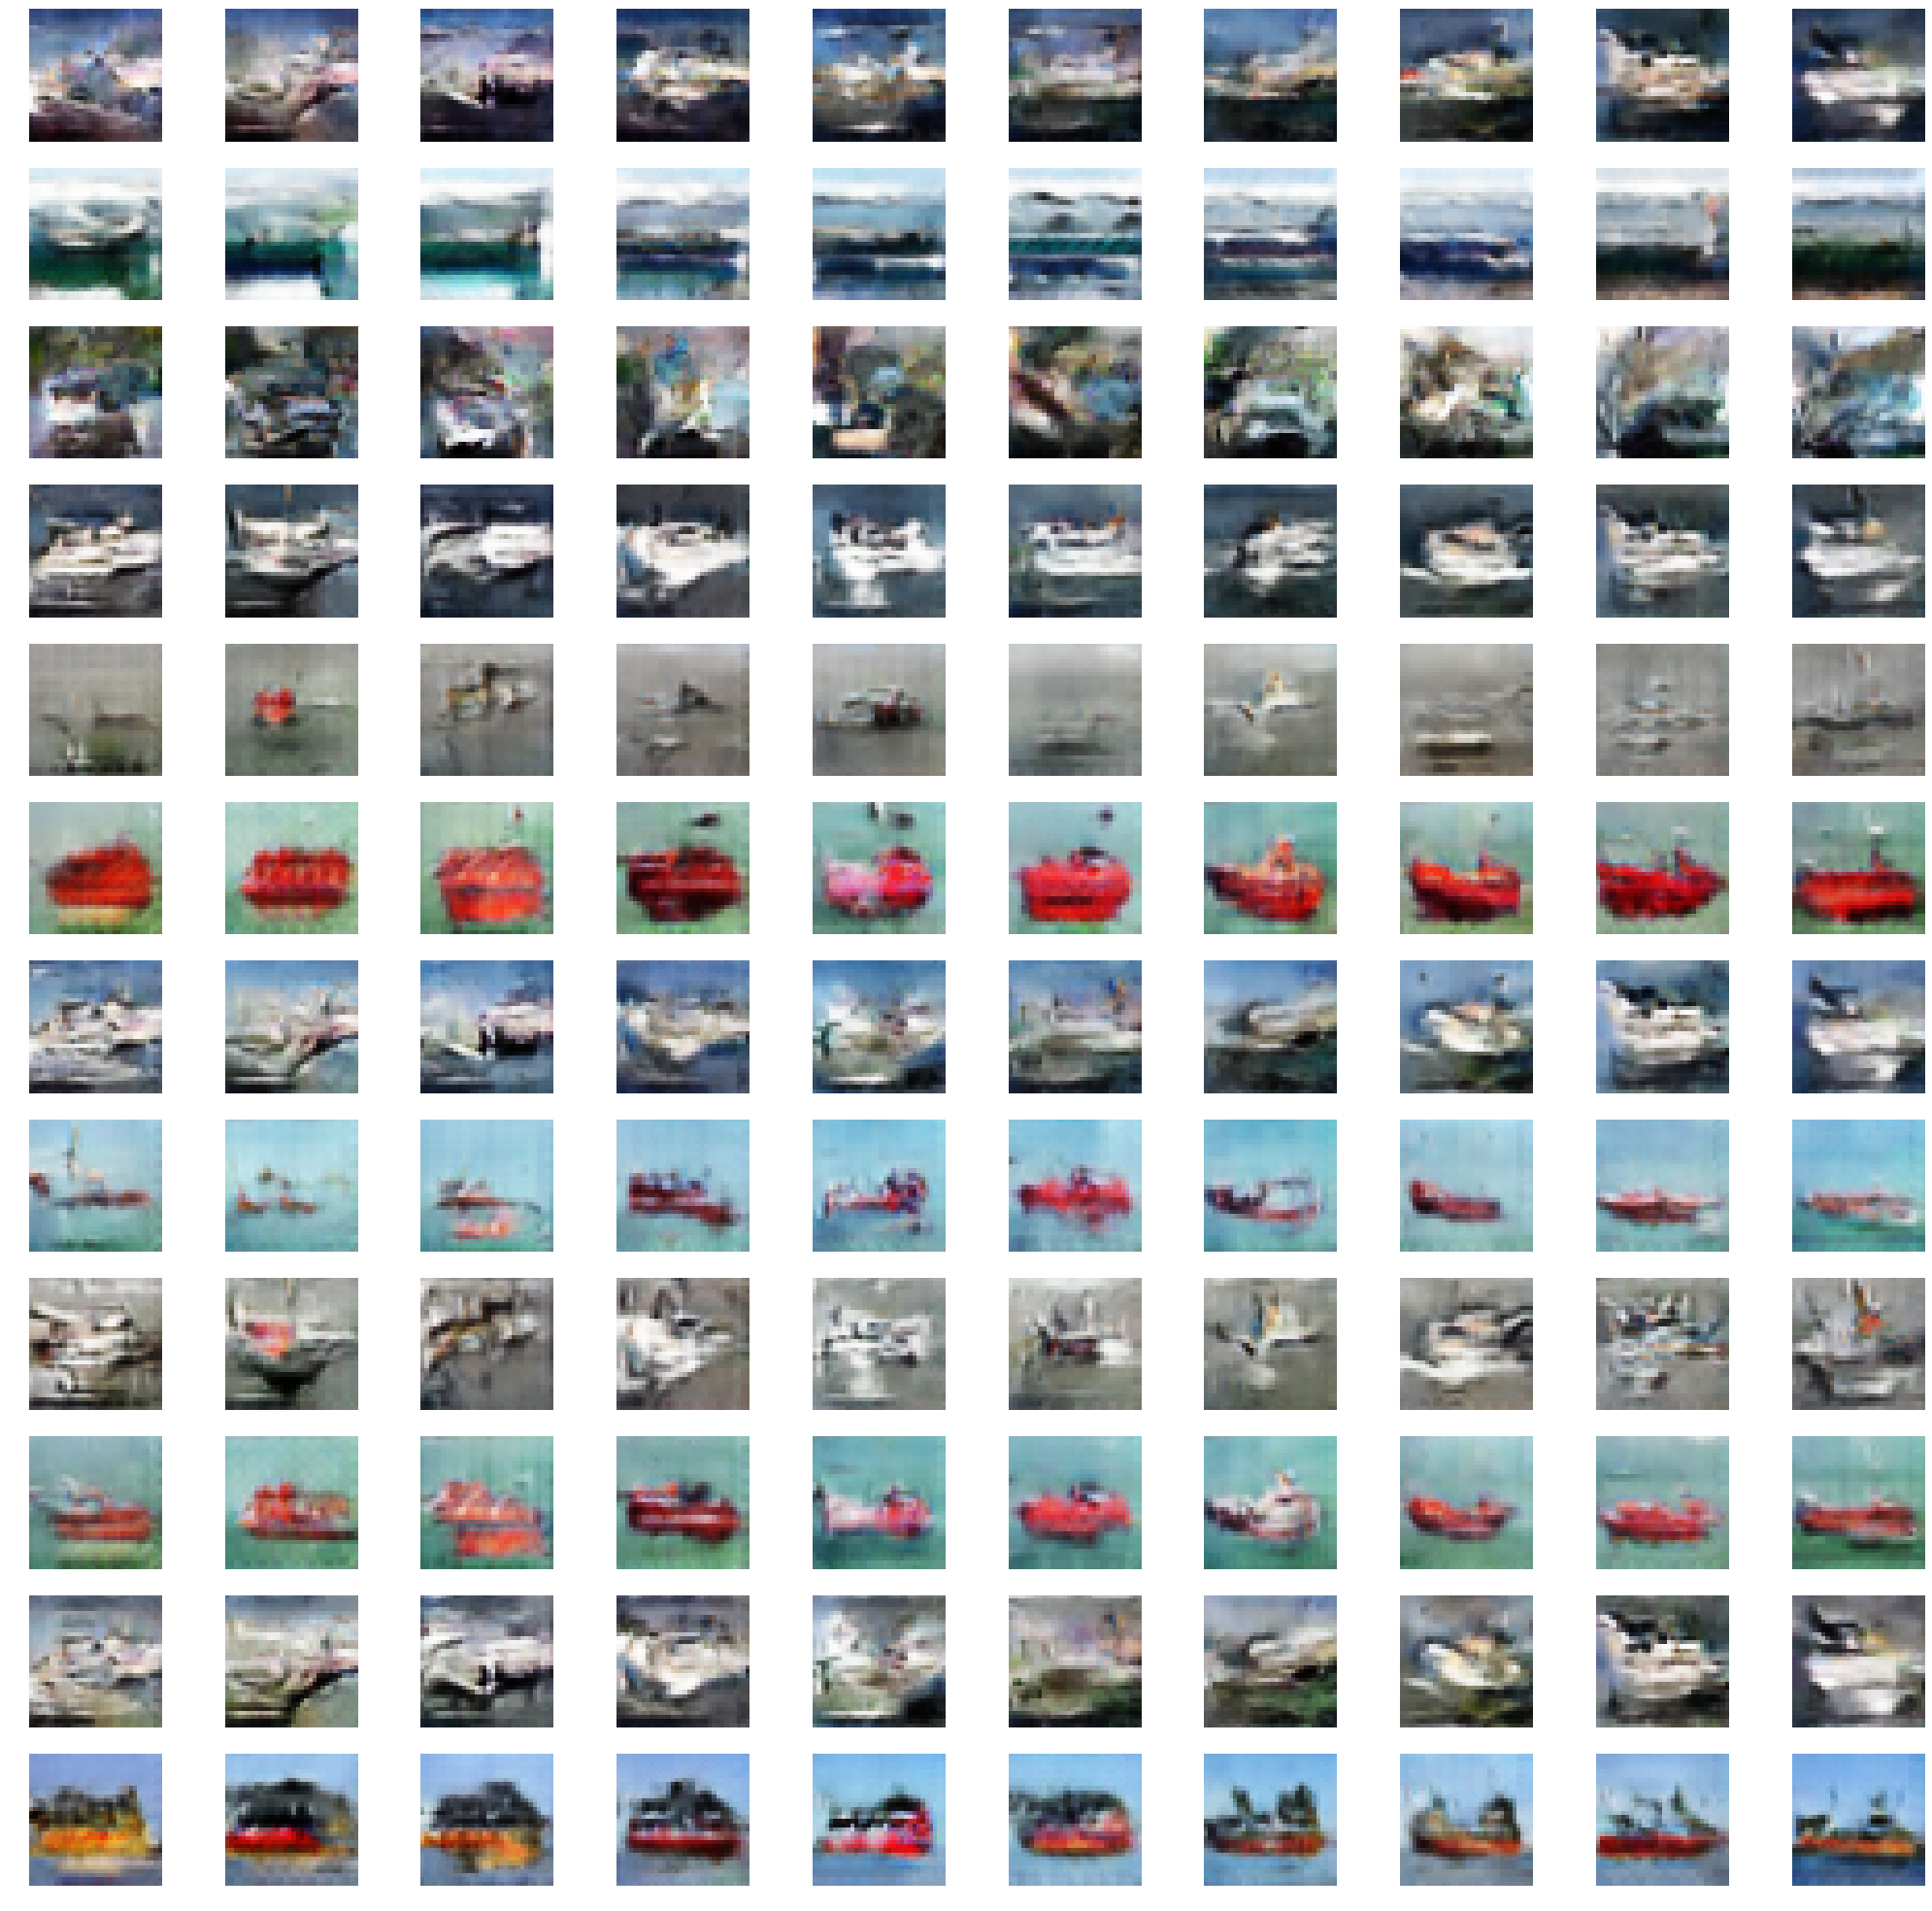

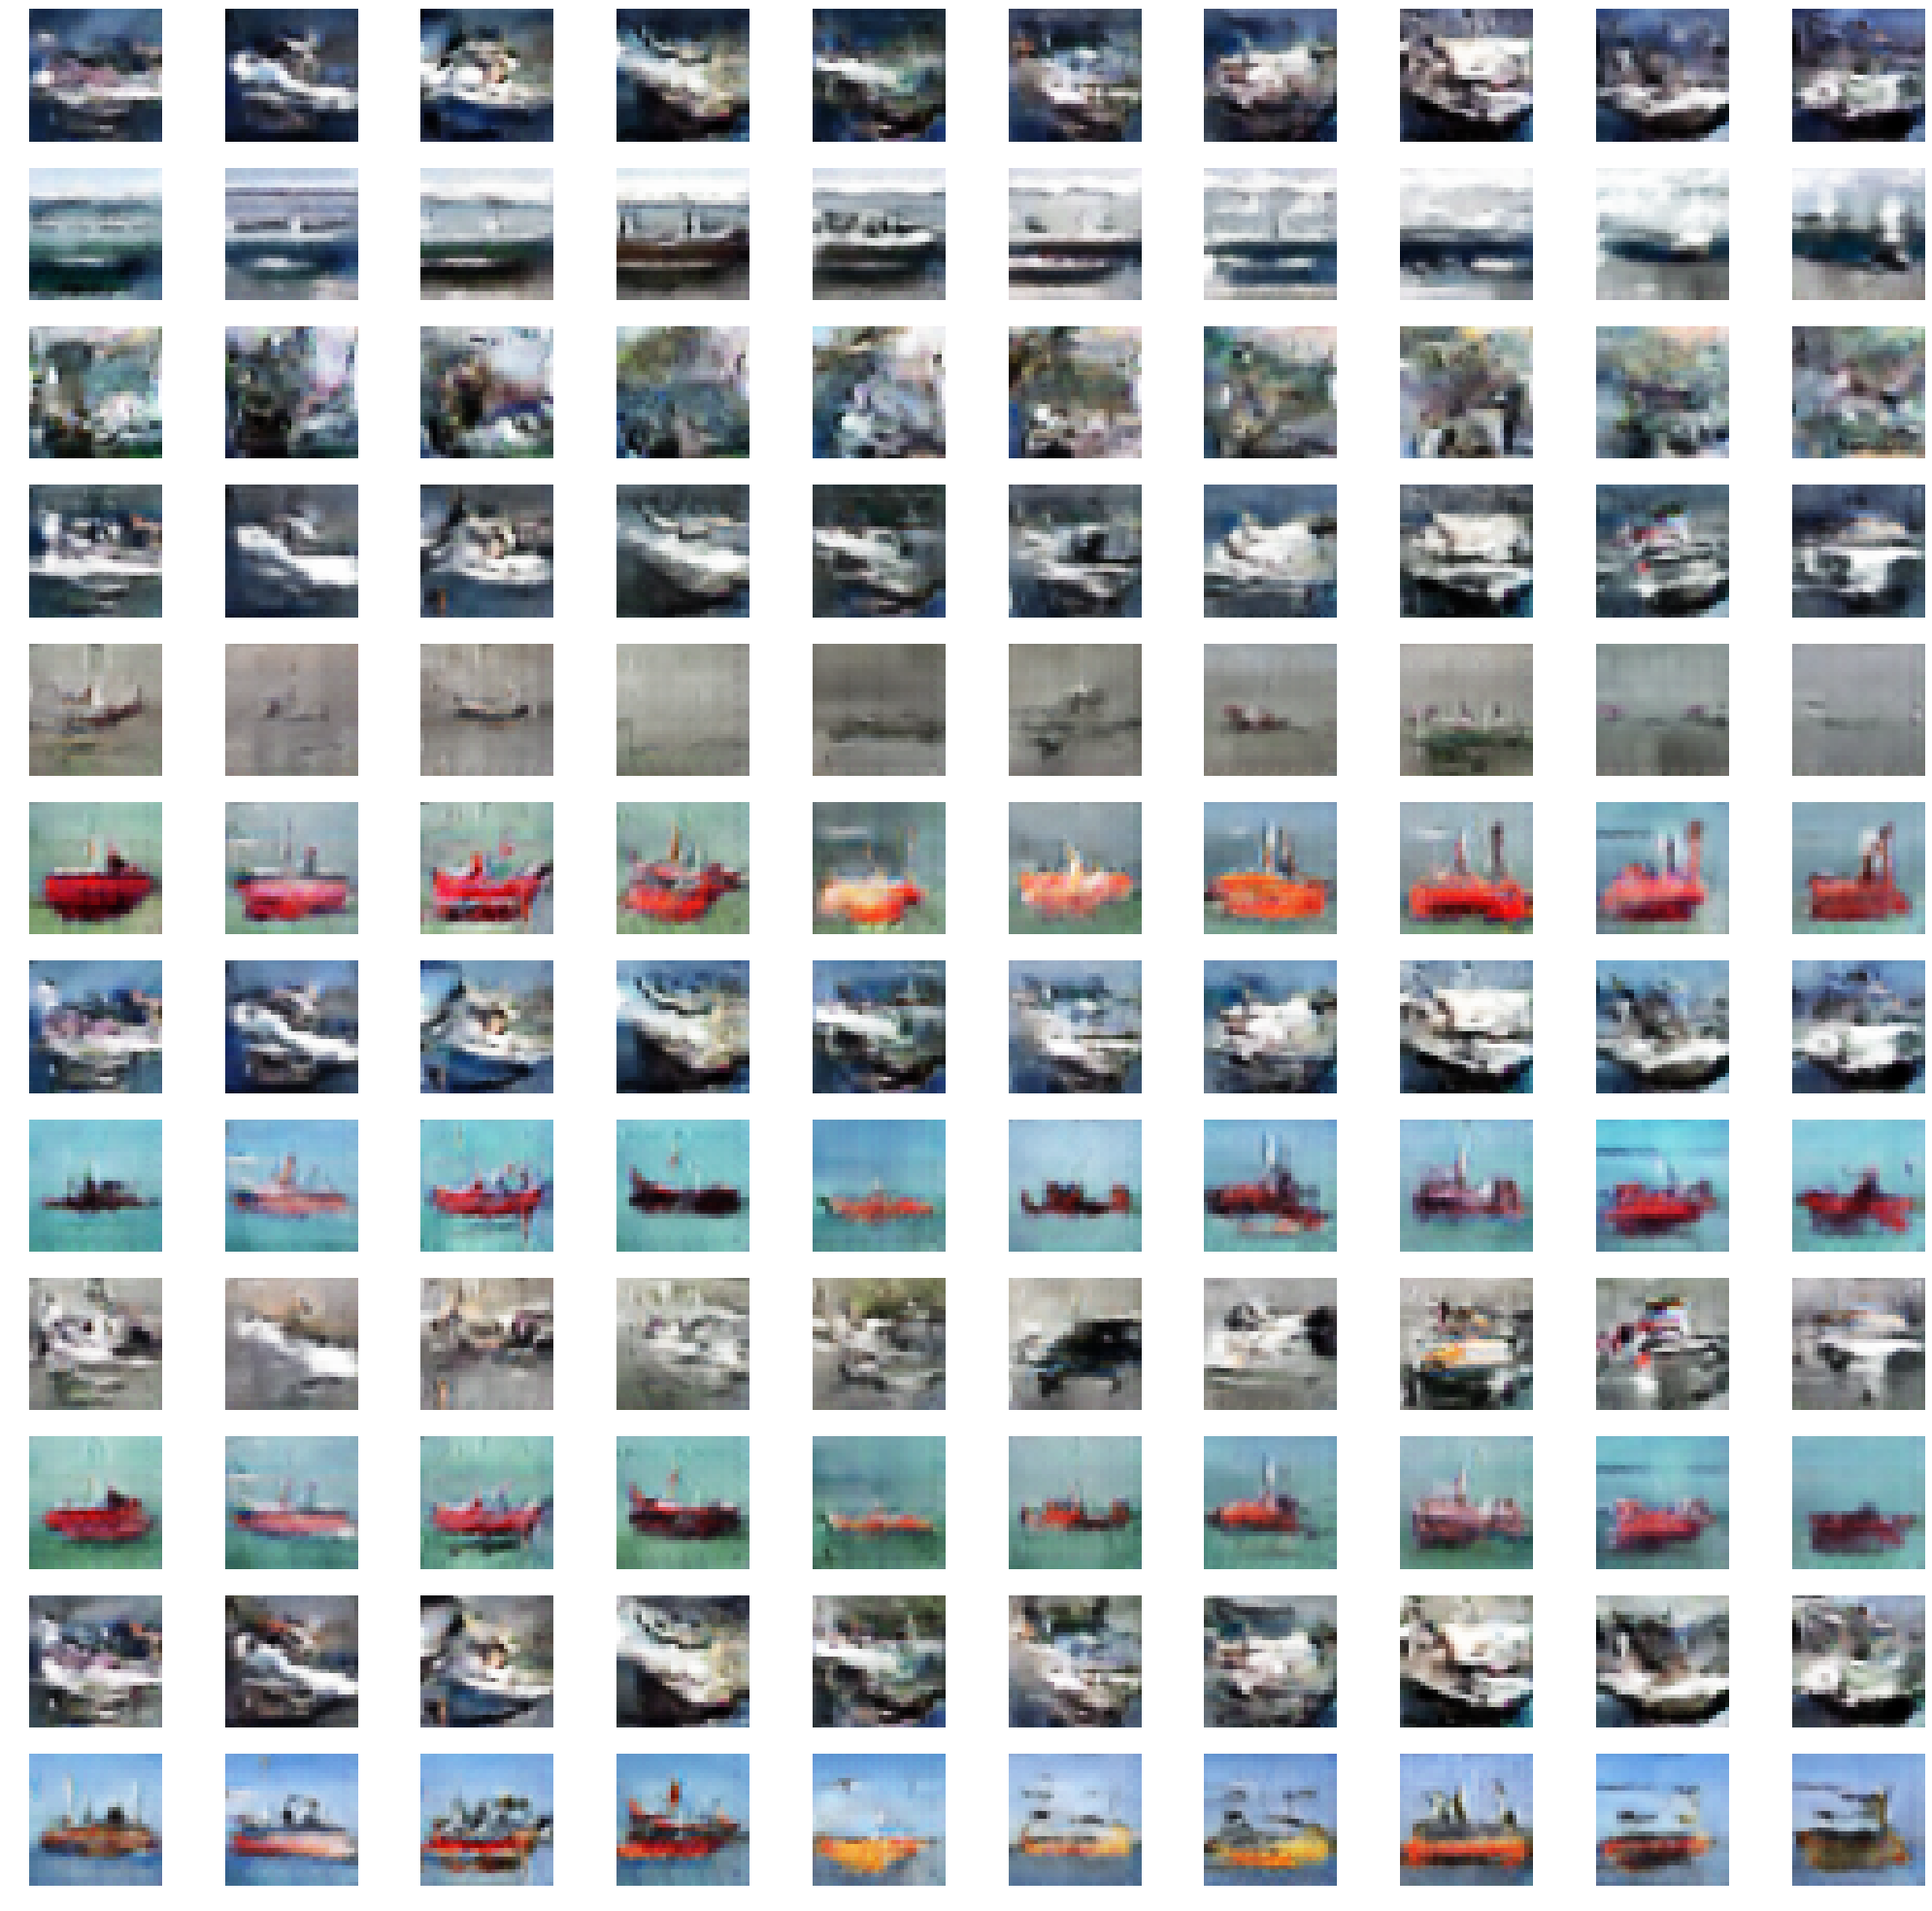

In [27]:
category = 8
num = 12
print(label_list[category])
times_per_run = 10
z = torch.randn(num, latent_size) # fix same random starter noise
total_step = 50//times_per_run
stopwatch()

comp_dir = os.path.join(sample_dir, "evolution")
if not os.path.exists(comp_dir): os.makedirs(comp_dir)
for k in range(total_step):
    fig = plt.figure(figsize=(32, 32), dpi=80)
    for j in range(times_per_run):
        epoch = (k*times_per_run+j+1)*20-1
        G.load_state_dict(torch.load(os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch))))
        imgs = generate_images(G, category, num, z)
        for i, img in enumerate(imgs):
            a=fig.add_subplot(num,times_per_run,i*times_per_run+j+1)
            plt.imshow(img.cpu().permute(1,2,0).numpy())
            plt.axis('off')
    plt.savefig(os.path.join(comp_dir, "category-{}_epoch-{}.png".format(label_list[category], epoch)))
    t = get_stopwatch()
    print('[{}/{}] ({:.1f}s)'.format(k+1, total_step, t), end="\r")
print("")

In [12]:
def one_hot_multi(x):
    r = torch.zeros([x.shape[0], num_labels] + list(x.shape[2:]))
    r.scatter_(1, x.unsqueeze(1), 1)
    return r
class Discriminator(nn.Module):
    def __init__(self, D):
        super(Discriminator, self).__init__()
        self.D = D
        
    def get_embedding(self, images, labels):
        if len(labels.shape) < 2 or labels.shape[1] != num_labels:
            labels = one_hot_multi(labels)
        labels = labels.unsqueeze(dim=-1).unsqueeze(dim=-1).expand(labels.shape+images.shape[2:])
        d_inputs = torch.cat((images, labels), 1).to(device)
        for module in list(D._modules.values())[:11]: # run up to just before the last Conv2d
            d_inputs = module(d_inputs)
        return d_inputs
    
    def forward(self, images, labels):
        d_inputs = self.get_embedding(images, labels)
        for module in list(D._modules.values())[11:]: # run remainder of network
            d_inputs = module(d_inputs)
        return d_inputs
discriminator = Discriminator(D)

fake_output = discriminator.get_embedding(imgs, torch.LongTensor([category]*num))
fake_output = fake_output.reshape(fake_output.shape[0], -1)

In [13]:
closest = [[] for i in range(num)]
topX = 5
total_step = len(dataset)
stopwatch()
test_category = category
print(label_list[test_category])
for i, (image, label) in enumerate(dataset):
    if label[test_category] < 0.5: continue
    output = discriminator.get_embedding(image.unsqueeze(0), label.unsqueeze(0))
    output = output.reshape(output.shape[0], -1)
    diffs = torch.sum((fake_output - output)**2, dim=1).data.tolist()
    for j, diff in enumerate(diffs):
        closest[j].append((i, diff))
        closest[j].sort(key=lambda x : x[1])
        closest[j] = closest[j][:topX]
    if (i+1) % 25 == 0:
        t = get_stopwatch()
        print('[{}/{}] ({:.1f}s/{:.1f}s)'.format(i+1, total_step, t, t*total_step/i), end="\r")
print("")

ships
[49925/50000] (19.6s/19.6s)


[12/12] (1.2s/1.3s)s)


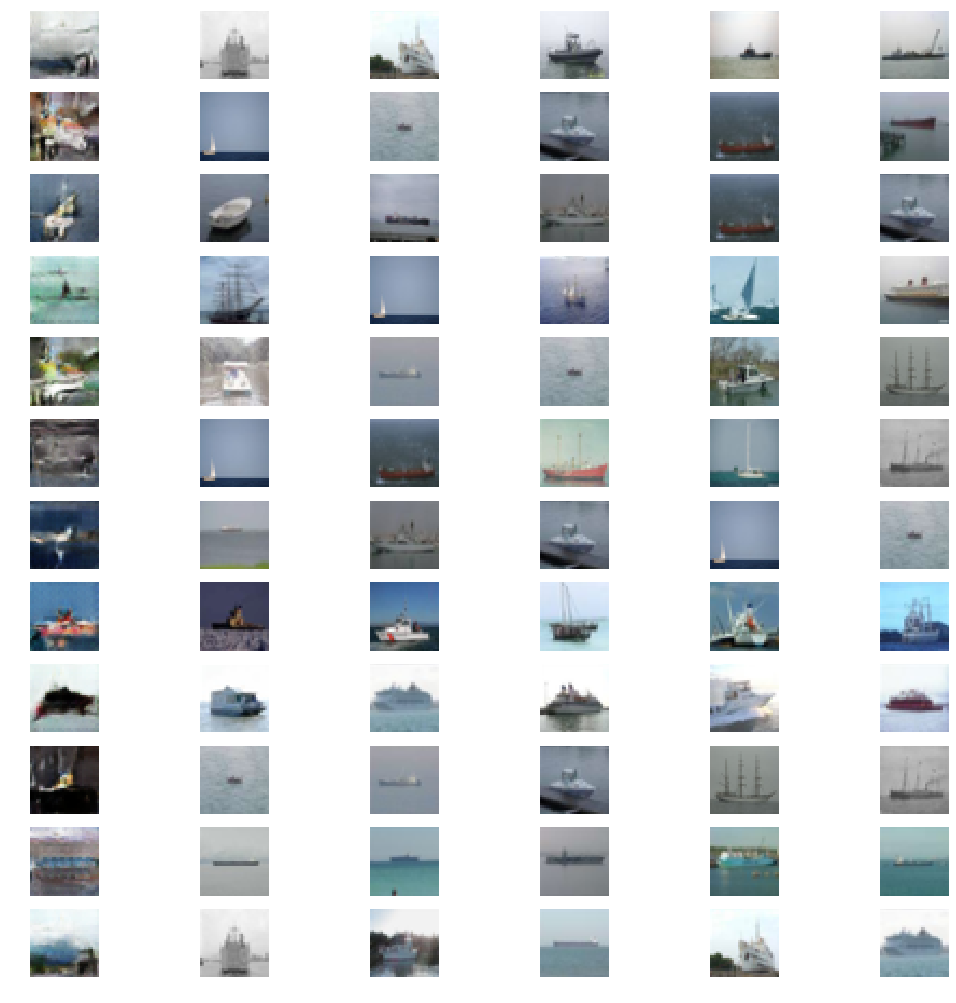

In [14]:
fig = plt.figure(figsize=(16, 16), dpi= 80)
stopwatch()
total_step = len(imgs)
for i, img in enumerate(imgs):
    a=fig.add_subplot(len(imgs),topX+1,1+i*(topX+1))
    plt.imshow(img.cpu().permute(1,2,0).numpy())
    plt.axis('off')
    for j, (c_id, _c_dist) in enumerate(closest[i]):
        real_img, _real_img_label = dataset[c_id]
        a=fig.add_subplot(len(imgs),topX+1,1+i*(topX+1)+1+j)
        plt.imshow(denorm(real_img.cpu().permute(1,2,0)))
        plt.axis('off')
    t = get_stopwatch()
    print('[{}/{}] ({:.1f}s/{:.1f}s)'.format(i+1, total_step, t, t*total_step/(i+0.001)), end="\r")
print("")